# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from scipy import stats
from IPython.display import HTML

np.set_printoptions(suppress=True)

In [153]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

## Generative Model Definition

The movement of any agent $a = 1, ..., A$ is both related to: 1) its interaction with surrounding neighbors $i = 1, ..., I$, which we call *internal influence*, and 2) their motivation to the surrounding spatial objects $j = 1, ..., J$, which we call *external influence*. These influences are modulated by a stationary weight, $w_a$:

\begin{equation}
    \theta_{a, t} = w_a \theta_{a|j, t} + (1 - w_a) \theta_{a|i, t}.
\end{equation}

### Meta-Variables

First, we define some meta-variables, such as the number of agents to simulate, the number of spatial beacons present in the environment, etc.

In [154]:
num_agents = 12
num_beacons = 2
room_size = (8., 10.)
world_size = 25.

### Agent Initialization

First, we initialize the agents with a randomized position and orientation, both uniformly distributed.

In [155]:
def initialize_agents(
    num_agents: int = 12, 
    room_size: tuple = (8., 10.),
):
    """
    Generate random positions and orientations for agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100.0).

    Returns
    -------
    tuple of np.ndarray
        A tuple containing the positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    # Generate random positions within the boundary size centered at 0
    positions = np.random.uniform(-0.5, 0.5, (num_agents, 2)) * room_size
    
    # Generate random orientations (angles in radians between 0 and 2*pi)
    orientations = np.random.uniform(0, 2 * np.pi, num_agents)
    
    return positions, orientations

In [156]:
agent_positions, agent_directions = initialize_agents(room_size=room_size)
np.cos(agent_directions)

array([ 0.9389912 , -0.6498866 , -0.44069216, -0.39386696, -0.9819058 ,
       -0.07459854,  0.87535171, -0.14728385, -0.13305924,  0.45281342,
        0.80676443,  0.90467165])

Text(0, 0.5, 'y')

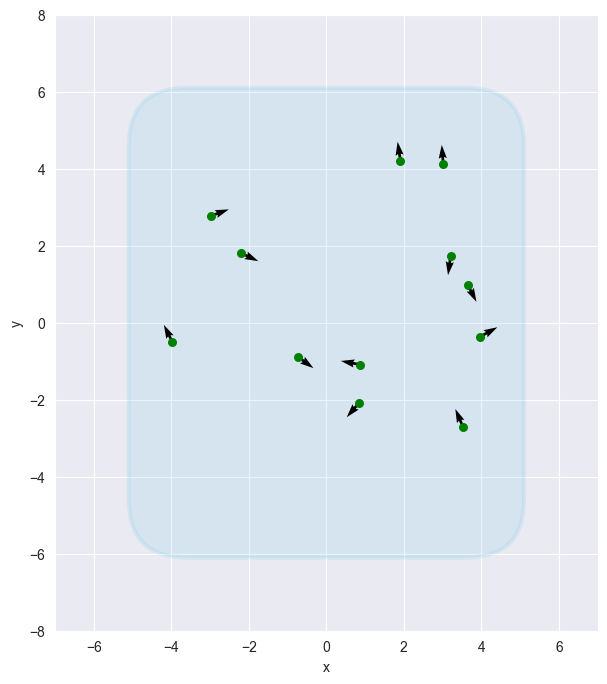

In [157]:
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

# Create a rounded rectangle with translucent face color
rounded_rect = FancyBboxPatch(
    (-5, -6),       # Lower left corner
    width=10.,        # Width
    height=12.,       # Height
    boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
    edgecolor=(0.53, 0.81, 0.92, 1),
    facecolor=(0.53, 0.81, 0.92, 0.2),
    linewidth=3,
    alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
)

ax.add_patch(rounded_rect)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    np.cos(agent_directions), np.sin(agent_directions), 
    angles='xy', scale_units="xy", 
    scale=2, width=0.005
)
ax.scatter(agent_positions[:, 0], agent_positions[:, 1], c='g', s=30)
ax.set_xlim([-7, 7])
ax.set_ylim([-8, 8])
ax.set_xlabel('x')
ax.set_ylabel('y')

### Beacon initialization

To intrinsically motivate the agents, we need a set of virtual beacons that are populated within the environment. The beacons have a freer representation with only positions needed.

In [158]:
def initialize_beacons(
        num_beacons = 10,
        room_sensing_range = 50.
):
    
    """
    Initialize beacons following a uniform distribution scaled to the room's sensing boundary
    
    Parameters
    ----------
    num_beacons : int, default: 10
        Number of beacons to initialize.
    room_sensing_range : float, default: 50.0
        Size of the environment for the generation of beacons.
    
    Returns
    -------
    beacons      : np.ndarray of shape (num_beacons, 2)
        Initial positions of the beacons. 
    """
    
    beacons = np.random.uniform(-room_sensing_range * 0.5, room_sensing_range * 0.5, size=(num_beacons, 2))
    return beacons

In [159]:
beacon_positions = initialize_beacons(num_beacons=6, room_sensing_range=world_size)
beacon_positions

array([[  8.40886113,  -4.43070157],
       [ -9.46396361,   8.35702401],
       [ -9.1764771 ,  -7.56732166],
       [ -2.5744818 , -12.36393658],
       [-11.88507448,  10.2631533 ],
       [  9.00697241,   5.20204037]])

Text(0, 0.5, 'y')

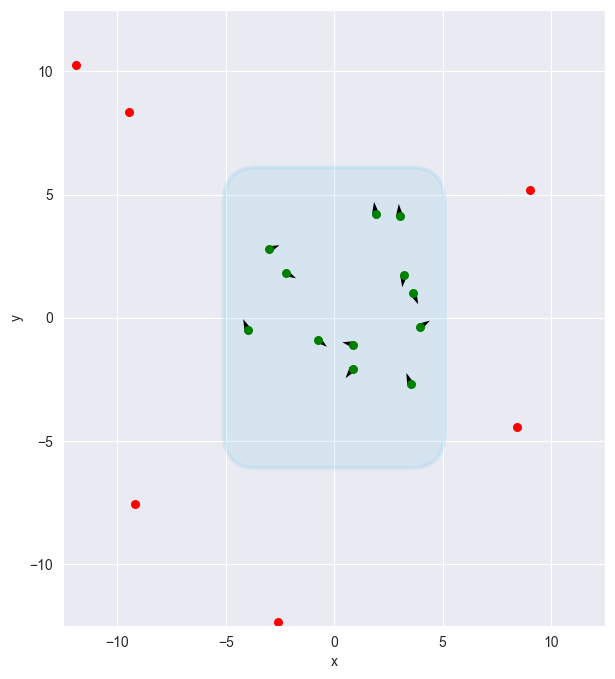

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

# Create a rounded rectangle with translucent face color
rounded_rect = FancyBboxPatch(
    (-5, -6),       # Lower left corner
    width=10.,        # Width
    height=12.,       # Height
    boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
    edgecolor=(0.53, 0.81, 0.92, 1),
    facecolor=(0.53, 0.81, 0.92, 0.2),
    linewidth=3,
    alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
)

ax.add_patch(rounded_rect)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    np.cos(agent_directions), np.sin(agent_directions), 
    angles='xy', scale_units="xy", 
    scale=2, width=0.005
)
ax.scatter(agent_positions[:, 0], agent_positions[:, 1], c='g', s=30)
ax.scatter(beacon_positions[:, 0], beacon_positions[:, 1], c='r', s=30)
ax.set_xlim([-0.5 * world_size, 0.5 * world_size])
ax.set_ylim([-0.5 * world_size, 0.5 * world_size])
ax.set_xlabel('x')
ax.set_ylabel('y')

## External Influence: drift-diffusion vector

We want to compute the influence of agent movement direction within a single time step. For this, we specify our internal influence as a 2D drift diffusion model, where the agents are approach a spatial beacon within the room's boundary by reorienting its locomotive direction.

\begin{equation}
    \theta_{a|j, t} = \theta_{a|j, t-1} + \omega_a \mathrm{d}t + \mathrm{d}\phi_t,
\end{equation}

\begin{align}
    \mathrm{d}\mathbf{x}_{a|j, t} 
    &= v_{a|j}\mathrm{d}t \frac{\mathbf{x}_{a|j}}{||\mathbf{x}_{a|j}||} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t \\
    &= v_{a}\mathrm{d}t     
    \begin{bmatrix}
        \cos \theta_{a|j, t} \\
        \sin \theta_{a|j, t}
    \end{bmatrix} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t,% \sqrt{\mathrm{d}t} Z_t.
\end{align}

In [177]:
def external_influence( 
    agent_position: np.ndarray,
    target_position: np.ndarray = np.array([1.0, 1.0]),
    noise: float = 0.1
):
    """
    Generate a drift-diffusion vector in 2D space for a single agent 
    based on a target location (in this case, the position of a beacon).

    Parameters
    ----------
    agent_position : np.ndarray
        The position of the agent.
    target_position : np.ndarray
        The position of the target beacon.
    noise : float, optional
        The rate of diffusion, which determines the variability of the direction (default is 0.1).

    Returns
    -------
    np.ndarray
        A 2D vector representing the drift-diffusion process towards the target (beacon).
    """
    # Calculate the angle towards the beacon (in radian)
    target_angle = np.arctan2(
        target_position[1] - agent_position[1], 
        target_position[0] - agent_position[0]
    ).astype(np.float32)
    
    # Generate a random direction with drift around the target angle
    direction = np.random.vonmises(target_angle, noise)
    
    # Convert the angle to a unit vector in 2D space
    v = np.array([np.cos(direction), np.sin(direction)], dtype=np.float32)
    
    return v, direction

In [188]:
ve, direction = external_influence(agent_positions[0], beacon_positions[0])
direction

-2.1730238146274523

## Internal Influence: particle dynamics

Its influence by a collective group of agents is modeled as a self-propelling particle system, as expressed in the Vicsek model:

\begin{align}
    \theta_{a|i, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a|i,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|i, t} \\
        \sin \theta_{a|i, t}
    \end{bmatrix},
\end{align}

In [186]:
def internal_influence(
    self_position: np.ndarray,
    neighbor_positions: np.ndarray, 
    neighbor_rotations: np.ndarray, 
    sensing_radius: float, 
    noise: float = 0.1
):
    """
    Generate an influence vector for a single agent 
    based on the angular component of the Vicsek model.

    Parameters
    ----------
    self_position : np.ndarray of shape (2,)
        A 2D vector representing the position of the agent
    neighbor_positions : np.ndarray of shape (2,)
        A 2D vector representing the positions of the neighboring agents.
    neighbor_rotations : np.ndarray of shape (2,)
        A 2D vector representing the rotations of the neighboring agents.
    sensing_radius : float
        The sensing radius within which agents interact with their neighbors.
    noise : float, optional
        The level of noise to add to the average direction (default is 0.1).

    Returns
    -------
    np.ndarray
        A 2D unit vector representing the averaged influence direction with added noise.
    """
    
    # Find neighbors within sensing radius
    distances = np.linalg.norm(neighbor_positions - self_position, axis=1)
    neighbors_idx = np.where(distances < sensing_radius)[0]
        
    # Calculate the average orientation of neighbors
    average_neighbor_rotation = np.arctan2(
        np.mean(np.sin(neighbor_rotations[neighbors_idx])),
        np.mean(np.cos(neighbor_rotations[neighbors_idx]))
    )
        
    # Add noise to the average orientation
    direction = (average_neighbor_rotation + np.random.vonmises(0, noise)).astype(np.float32)
    
    # Convert the orientation to a unit vector in 2D space
    v = np.array([np.cos(direction), np.sin(direction)], dtype=np.float32)
    
    return v, direction

In [189]:
agent_positions, agent_rotations = initialize_agents(12, room_size=room_size)
vi, direction = internal_influence(agent_positions[0], agent_positions, agent_rotations, sensing_radius=2.5, noise=0.1)
direction

-2.2006881

### Putting everything together: combined influences

In [147]:
def update_agents(
    agent_positions: np.ndarray, 
    agent_rotations: np.ndarray, 
    velocity: float = 1.0, 
    sensing_radius: float = 2.5,
    ddm_vector: np.ndarray = None, 
    vicsek_vector: np.ndarray = None, 
    dt: float = 0.1, 
    influence_weight: float = 0.7
):
    """
    Update the positions and orientations of agents based on velocity and influence vectors.

    Parameters
    ----------
    agent_positions : np.ndarray
        Current positions of the agents.
    agent_rotations : np.ndarray
        Current orientations of the agents.
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    sensing_radius : float, optional
        The sensing radius within which agents interact with their neighbors.
    ddm_vector : np.ndarray, optional
        The first influence vector affecting agent orientation. If None, it will be generated using drift-diffusion (default is None).
    vicsek_vector : np.ndarray, optional
        The second influence vector affecting agent orientation. If None, it will be generated using the Vicsek model (default is None).
    dt : float, optional
        The time step for updating positions and orientations (default is 0.1).
    influence_weight : float, optional
        The weight of influence_vector1 in determining new orientations (default is 0.7).

    Returns
    -------
    tuple of np.ndarray
        Updated positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    # Generate influence_vector1 if not provided
    if ddm_vector is None:
        ddm_vector = external_influence()
    
    # Generate influence_vector2 if not provided
    if vicsek_vector is None:
        vicsek_vector = internal_influence(agent_rotations, sensing_radius=sensing_radius)
    
    # Update positions based on current orientations
    agent_positions[:, 0] += velocity * np.cos(agent_rotations) * dt
    agent_positions[:, 1] += velocity * np.sin(agent_rotations) * dt
    
    # Update orientations based on two influence vectors
    ddm_influence = np.arctan2(ddm_vector[1], ddm_vector[0])
    vicsek_influence = np.arctan2(vicsek_vector[1], vicsek_vector[0])
    
    # Combine influences to update orientations with different weights
    agent_rotations += (influence_weight * ddm_influence + (1 - influence_weight) * vicsek_influence) * dt
    
    # Ensure orientations are within the range [0, 2*pi]
    agent_rotations = np.mod(agent_rotations, 2 * np.pi)
    
    return agent_positions, agent_rotations

In [148]:
def simulator_fun(
    num_agents: int = 100, 
    num_beacons: int = 1,
    room_size: np.ndarray = np.array([8., 10.]),
    velocity: float = 1.0, 
    dt: float = 0.1, 
    influence_weight: float = 0.7, 
    sensing_radius: float = 10.0,
    num_timesteps: int = 100
):
    """
    Run the simulation and store the time series of positions and orientations of agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    num_beacons : int, optional
        Number of beacons to generate (default is 1).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100).
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    dt : float, optional
        The time step for the update (default is 0.1).
    influence_weight : float, optional
        The weight for influence_vector1 in determining new orientations (default is 0.7).
    sensing_radius : float, optional
        The sensing radius for the Vicsek model (default is 10.0).
    num_timesteps : int, optional
        The number of steps to simulate (default is 100).

    Returns
    -------
    tuple of np.ndarray
        The time series of positions and orientations of the agents.
    """
    # Initialize positions and orientations
    positions, orientations = initialize_agents(num_agents, room_size)

    # Initialize arrays to store time series of positions and orientations
    positions = [positions.copy()]
    orientations = [orientations.copy()]
    
    # Initialize beacons
    beacons = initialize_beacons(num_beacons)

    # Simulation loop
    for t in range(num_timesteps):
        ddm = external_influence(positions, target_position=np.array([1.0, 1.0]))  # Update the drift-diffusion vector each step
        vicsek = internal_influence(positions, orientations, sensing_radius)  # Update the Vicsek influence vector each step
        positions, orientations = update_agents(positions, orientations, velocity, sensing_radius, ddm, vicsek, dt=dt, influence_weight=influence_weight)
        
        # Store positions and orientations for each time step
        positions.append(positions.copy())
        orientations.append(orientations.copy())

    # Convert lists to numpy arrays for easier manipulation
    positions = np.array(positions)
    orientations = np.array(orientations)

    return positions, orientations

# Priors

In [149]:
param_names = [
    r"$w$",
    r"$r$",
    r"$\sigma$",
    r"$v$",
    r"$\omega$"
]

In [150]:
def prior_fun():
    weight = np.random.beta(2, 5)
    radius = 1 / np.random.gamma(2, 1)
    sigma = np.random.gamma(2, 2)
    v = np.random.beta(2, 2)
    omega = np.random.vonmises(0, np.pi)
    return np.array([weight, radius, sigma, v, omega])

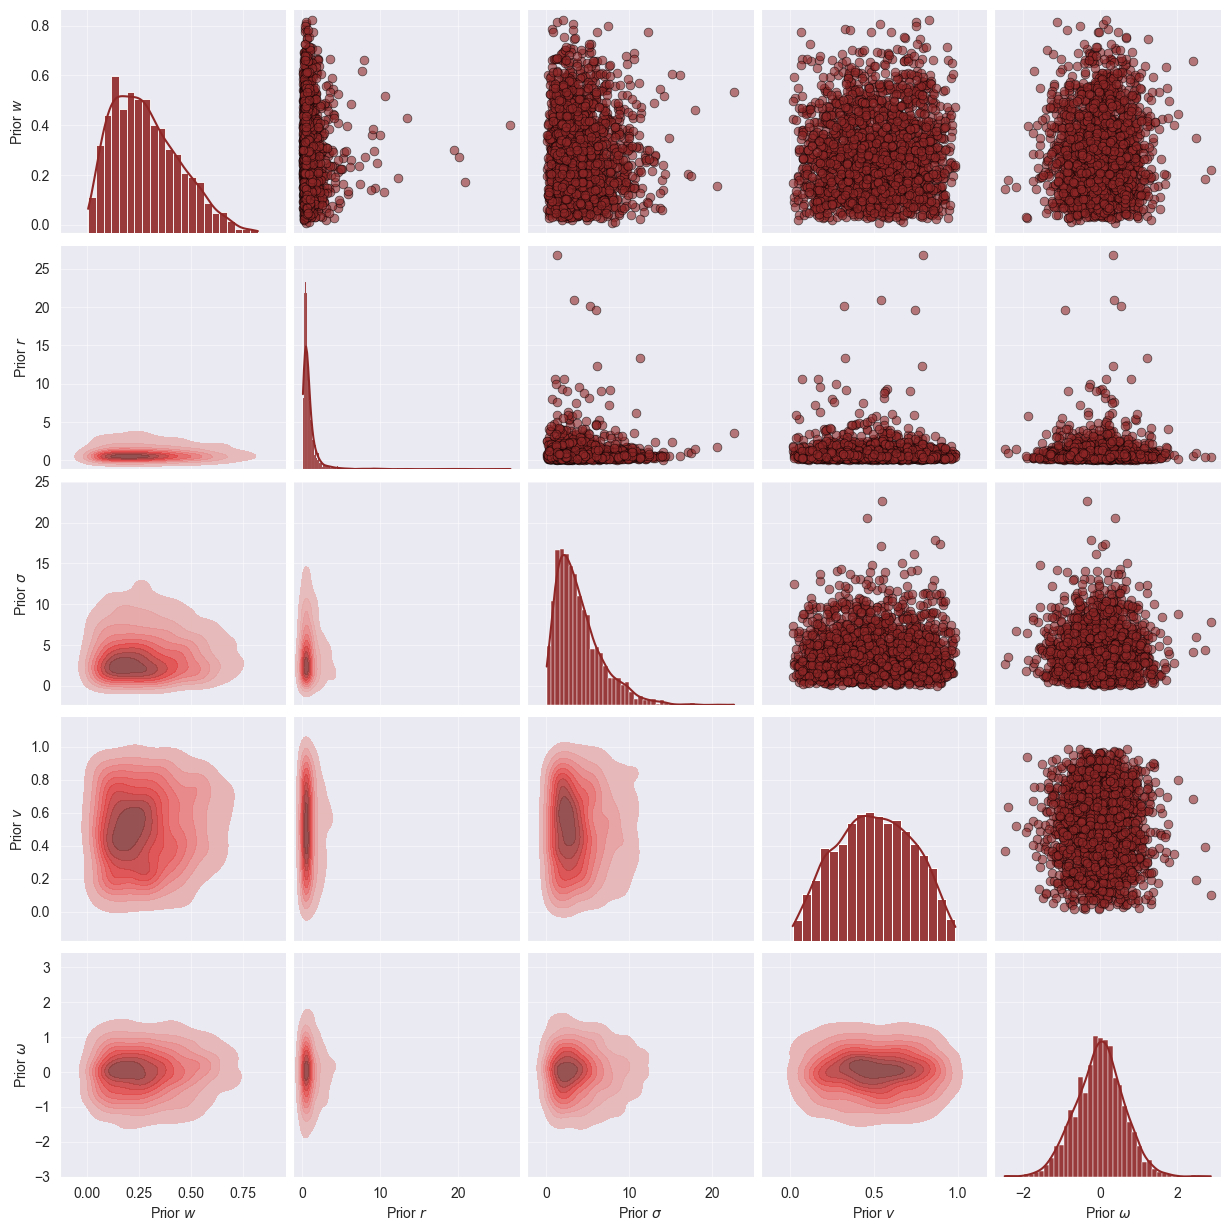

In [151]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)
f = prior.plot_prior2d()

# Generative Model

In [131]:
simulator = Simulator(simulator_fun=simulator_fun)

model = GenerativeModel(
    prior=prior,
    simulator=simulator,
    simulator_is_batched=False
)

TypeError: only integer scalar arrays can be converted to a scalar index

# Configurator

In [46]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

# Neural Approximator

In [47]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=5,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)


amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)


trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

NameError: name 'model' is not defined